In [1]:
!sudo apt-get install tree -qq > /dev/null

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


In [23]:
os.listdir()

['.config', 'data', 'yolov5', 'content', 'gdrive', 'sample_data']

In [2]:
!nvidia-smi

Thu Apr  8 19:24:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
! git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
! pip install -r requirements.txt  # install

Cloning into 'yolov5'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 5659 (delta 9), reused 5 (delta 1), pack-reused 5636
Receiving objects: 100% (5659/5659), 8.20 MiB | 34.26 MiB/s, done.
Resolving deltas: 100% (3863/3863), done.
/content/yolov5
     |████████████████████████████████| 645kB 19.3MB/s 
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
import zipfile
import os
import time

from google.colab import drive
from PIL import Image, ImageDraw

from pathlib import Path
from tqdm import tqdm
import numpy as np
import json
import urllib
import PIL.Image as Image
import cv2
import torch
import torchvision
from IPython.display import display
from sklearn.model_selection import train_test_split
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10
np.random.seed(42)

In [5]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [6]:
zip_file = '/content/gdrive/MyDrive/data/faces/kaggle_dataset/archive.zip'
z = zipfile.ZipFile(zip_file, 'r')
z.extractall('/content/data/unprocessed/kaggle/')

In [7]:
import cv2
import xml.etree.ElementTree as ET
import xml.dom.minidom as minidom

def process_kaggle(input_images_path, input_labels_path, all_to_val = 5, kaggle_name='kaggle'):
    mask_count = 0
    images_path_train = Path(f"faces/images/train")
    images_path_train.mkdir(parents=True, exist_ok=True)
    images_path_val = Path(f"faces/images/val")
    images_path_val.mkdir(parents=True, exist_ok=True)

    labels_path_train = Path(f"faces/labels/train")
    labels_path_train.mkdir(parents=True, exist_ok=True)
    labels_path_val = Path(f"faces/labels/val")
    labels_path_val.mkdir(parents=True, exist_ok=True)

    i = 0
    labels = os.listdir(input_labels_path)
    for label_name in labels:
      i += 1
      cur_images_path = images_path_val if i % all_to_val == 0 else images_path_train
      cur_labels_path = labels_path_val if i % all_to_val == 0 else labels_path_train
      annotation = minidom.parse(input_labels_path + label_name)

      img_name = annotation.getElementsByTagName('filename')[0].firstChild.data
      img = Image.open(input_images_path + img_name)
      img = img.convert('RGB')
      img.save(str(cur_images_path / f'{kaggle_name}{i}.jpg'), "JPEG")

      with(cur_labels_path / f'{kaggle_name}{i}.txt').open(mode='w') as label_file:
        objects = annotation.getElementsByTagName('object')
        for obj in objects:
          bndbox = obj.getElementsByTagName('bndbox')[0]
          xmin = int(bndbox.getElementsByTagName('xmin')[0].firstChild.data)
          ymin = int(bndbox.getElementsByTagName('ymin')[0].firstChild.data)
          xmax = int(bndbox.getElementsByTagName('xmax')[0].firstChild.data)
          ymax = int(bndbox.getElementsByTagName('ymax')[0].firstChild.data)

          label = obj.getElementsByTagName('name')[0].firstChild.data
          if kaggle_name == 'kaggle': 
            label_id = 0 if label == 'mask' else 1
          else:
            label_id = 0 if label == 'with_mask' else 1
          mask_count += (1 - label_id)
          w, h = img.size
          x, y = (xmin + xmax) / 2 / w, (ymin + ymax) / 2 / h
          bw, bh = abs(xmax - xmin) / w, abs(ymax - ymin) / h
          
          label_file.write(f'{label_id} {x} {y} {bw} {bh}\n')
    print(mask_count)

In [24]:
process_kaggle(
    input_images_path='/content/data/unprocessed/kaggle/medical-masks-dataset/images/',
    input_labels_path='/content/data/unprocessed/kaggle/medical-masks-dataset/labels/',
)

4154


In [25]:
def test_dataset(name):
  image = Image.open(f'faces/images/{name}.jpg')

  img_draw = image.copy()
  draw = ImageDraw.Draw(img_draw)
  with open(f'faces/labels/{name}.txt') as f:
    for box in f:
      box = box.strip().split()
      x, y, bw, bh = float(box[1]), float(box[2]), float(box[3]), float(box[4])
      w, h = image.size

      x1, y1 = (x - bw / 2) * w, (y - bh / 2) * h
      x2, y2 = x1 + bw * w, y1 + bh * h
      
      outline = (255, 0, 0) if int(box[0]) else (0, 255, 0)
      draw.rectangle([x1, y1, x2, y2], outline=outline, width=2)
  
  return img_draw

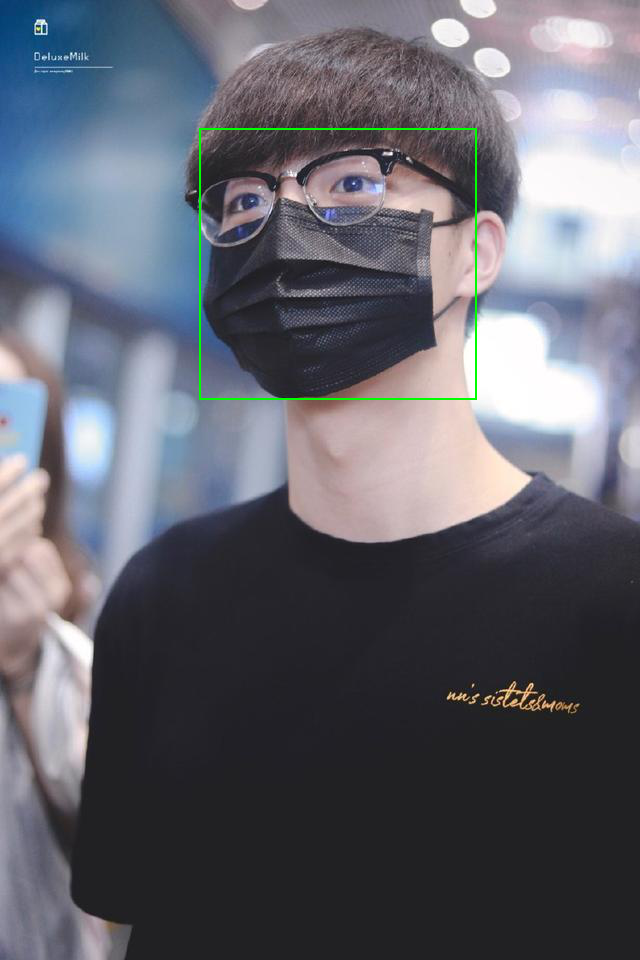

In [26]:
test_dataset('train/kaggle221')

In [27]:
zip_file = '/content/gdrive/MyDrive/data/faces/kaggle_dataset2/archive.zip'
z = zipfile.ZipFile(zip_file, 'r')
z.extractall('/content/data/unprocessed/kaggle2/')

In [28]:
process_kaggle(
    input_images_path='/content/data/unprocessed/kaggle2/images/',
    input_labels_path='/content/data/unprocessed/kaggle2/annotations/',
    kaggle_name='kaggle2_'
)

3232


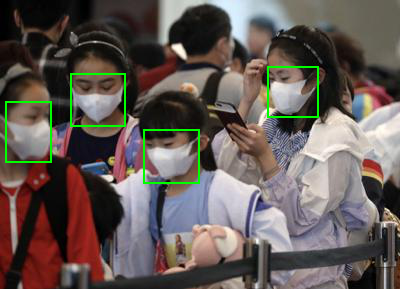

In [29]:
test_dataset('train/kaggle2_13')

In [30]:
len(os.listdir('/content/faces/images/train'))

1602

In [31]:
!zip -r '/content/gdrive/MyDrive/data/faces/two_kaggle_darknet.zip' '/content/faces'

  adding: content/faces/ (stored 0%)
  adding: content/faces/images/ (stored 0%)
  adding: content/faces/images/train/ (stored 0%)
  adding: content/faces/images/train/kaggle454.jpg (deflated 0%)
  adding: content/faces/images/train/kaggle183.jpg (deflated 12%)
  adding: content/faces/images/train/kaggle2_42.jpg (deflated 1%)
  adding: content/faces/images/train/kaggle733.jpg (deflated 7%)
  adding: content/faces/images/train/kaggle612.jpg (deflated 1%)
  adding: content/faces/images/train/kaggle2_554.jpg (deflated 1%)
  adding: content/faces/images/train/kaggle2_297.jpg (deflated 1%)
  adding: content/faces/images/train/kaggle2_301.jpg (deflated 1%)
  adding: content/faces/images/train/kaggle642.jpg (deflated 0%)
  adding: content/faces/images/train/kaggle2_562.jpg (deflated 2%)
  adding: content/faces/images/train/kaggle46.jpg (deflated 0%)
  adding: content/faces/images/train/kaggle644.jpg (deflated 3%)
  adding: content/faces/images/train/kaggle2_468.jpg (deflated 2%)
  adding: con

In [6]:
zip_file = '/content/gdrive/MyDrive/data/faces/two_kaggle_darknet.zip'
z = zipfile.ZipFile(zip_file, 'r')
z.extractall('/content/')

In [7]:
def test_dataset(name):
  image = Image.open(f'/content/content/faces/images/{name}.jpg')

  img_draw = image.copy()
  draw = ImageDraw.Draw(img_draw)
  with open(f'/content/content/faces/labels/{name}.txt') as f:
    for box in f:
      box = box.strip().split()
      x, y, bw, bh = float(box[1]), float(box[2]), float(box[3]), float(box[4])
      w, h = image.size

      x1, y1 = (x - bw / 2) * w, (y - bh / 2) * h
      x2, y2 = x1 + bw * w, y1 + bh * h
      
      outline = (255, 0, 0) if int(box[0]) else (0, 255, 0)
      draw.rectangle([x1, y1, x2, y2], outline=outline, width=2)
  
  return img_draw

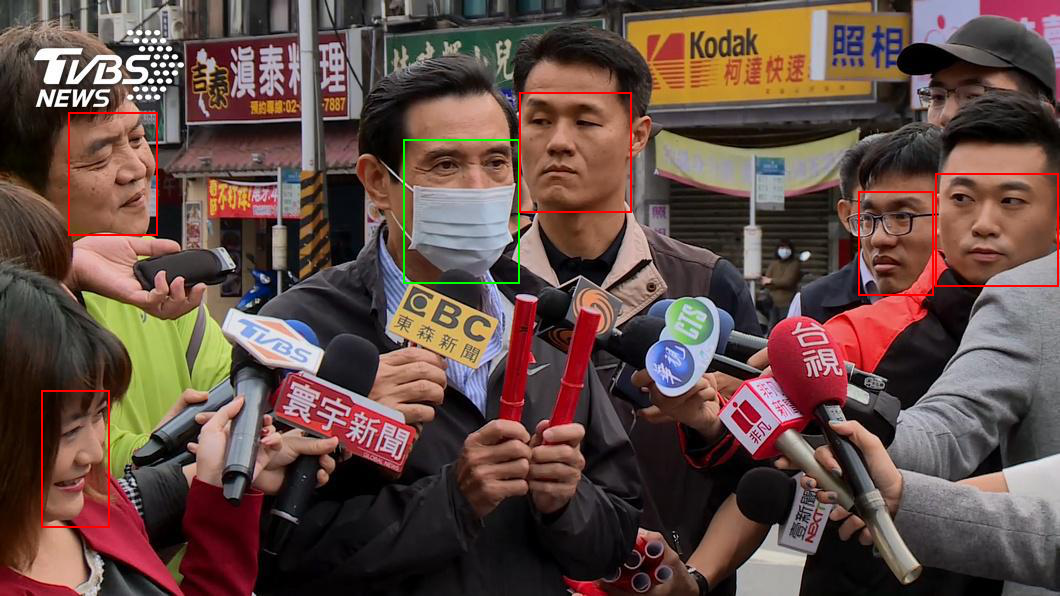

In [8]:

test_dataset('train/kaggle7')

In [9]:
zip_file = '/content/gdrive/MyDrive/data/faces/yolov5s_face_detector_weights.zip'
z = zipfile.ZipFile(zip_file, 'r')
z.extractall('/content/')

In [43]:
%cd yolov5

/content/yolov5


In [11]:
!python train.py --img 1024 --batch 16 --epochs 30 --data ./data/faces.yaml --cfg ./models/yolov5s.yaml --weights /content/content/yolov5/runs/train/exp/weights/best.pt

github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v4.0-189-gc03d590 torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, artifact_alias='latest', batch_size=16, bbox_interval=-1, bucket='', cache_images=False, cfg='./models/yolov5s.yaml', data='./data/faces.yaml', device='', entity=None, epochs=30, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[1024, 1024], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/exp', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=16, upload_dataset=False, weights='/content/content/yolov5/runs/train/exp/weights/best.pt', workers=8, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
2021-04-08 19:27:00.371812: I tensorflow/stream_

In [12]:
!zip -r '/content/gdrive/MyDrive/data/faces/yolov5s_pretrained_on_wider_exp.zip' '/content/yolov5/runs/train/exp'

updating: content/yolov5/runs/train/exp/ (stored 0%)
updating: content/yolov5/runs/train/exp/opt.yaml (deflated 48%)
updating: content/yolov5/runs/train/exp/train_batch2.jpg (deflated 2%)
updating: content/yolov5/runs/train/exp/weights/ (stored 0%)
updating: content/yolov5/runs/train/exp/weights/last.pt (deflated 9%)
updating: content/yolov5/runs/train/exp/weights/best.pt (deflated 9%)
updating: content/yolov5/runs/train/exp/hyp.yaml (deflated 44%)
updating: content/yolov5/runs/train/exp/train_batch0.jpg (deflated 3%)
updating: content/yolov5/runs/train/exp/train_batch1.jpg (deflated 2%)
updating: content/yolov5/runs/train/exp/labels_correlogram.jpg (deflated 20%)
updating: content/yolov5/runs/train/exp/labels.jpg (deflated 20%)
updating: content/yolov5/runs/train/exp/results.txt (deflated 73%)
  adding: content/yolov5/runs/train/exp/events.out.tfevents.1617910021.a3b9518df2c4.545.0 (deflated 65%)
  adding: content/yolov5/runs/train/exp/P_curve.png (deflated 14%)
  adding: content/yolo